https://www.kaggle.com/code/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets



## 데이터 센스 수집:
<a id="gather"></a>
가장 먼저 해야 할 일은 데이터에 대한 <b> 기본 감각 </b> 을 수집하는 것입니다. <b>거래</b> 및 <b>금액</b>을 제외하고 다른 열이 무엇인지 알 수 없음을 기억하십시오(개인정보 보호상의 이유로). 우리가 아는 유일한 것은 알려지지 않은 열이 이미 크기가 조정되었다는 것입니다.

<h3> 요약: </h3>
<울>
<li>거래 금액이 상대적으로 <b>작습니다</b>. 제작된 모든 마운트의 평균은 약 USD 88입니다. </li>
<li><b>"Null"</b> 값이 없으므로 값을 대체할 방법을 모색할 필요가 없습니다. </li>
<li> 대부분의 거래는 시간의 <b>비 사기</b>(99.83%)인 반면, <b>사기</b> 거래는 데이터 프레임에서 발생하는 시간(017%)이었습니다. </li>
</ul>

<h3> 기능 기술: </h3>
<울>
<li> <b>PCA 변환: </b> 데이터 설명에 따르면 모든 기능이 PCA 변환(차원 축소 기법)을 거쳤습니다(시간 및 양 제외).</li>
<li> <b>크기 조정:</b> PCA 변환 기능을 구현하려면 미리 크기를 조정해야 합니다. (이 경우 모든 V 기능이 확장되었거나 최소한 데이터세트를 개발한 사람들이 그렇게 했다고 가정합니다.)</li>
</ul>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import time

# 차원축소
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD

# 모델
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections

# Other Libraries
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline

from imblearn.over_sampling import SMOTE # 오버샘플링
from imblearn.under_sampling import NearMiss # 언더샘플링

from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('./input/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [2]:
df.shape

(284807, 31)

In [3]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.918649e-15,5.682686e-16,-8.761736e-15,2.811118e-15,-1.552103e-15,2.040130e-15,-1.698953e-15,-1.893285e-16,-3.147640e-15,...,1.473120e-16,8.042109e-16,5.282512e-16,4.456271e-15,1.426896e-15,1.701640e-15,-3.662252e-16,-1.217809e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [4]:
# Good No Null Values!
df.isnull().sum().max()

0

In [5]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [6]:
# The classes are heavily skewed we need to solve this issue later.
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100, 2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100, 2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


**Note:**  Notice how imbalanced is our original dataset! Most of the transactions are non-fraud. If we use this dataframe as the base for our predictive models and analysis we might get a lot of errors and our algorithms will probably overfit since it will "assume" that most transactions are not fraud. But we don't want our model to assume, we want our model to detect patterns that give signs of fraud!

Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

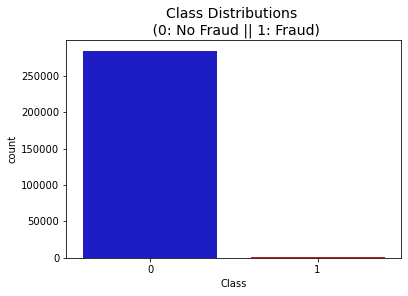

In [7]:
colors = ["#0101DF", "#DF0101"]

sns.countplot('Class', data=df, palette=colors)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

**Distributions:** By seeing the distributions we can have an idea how skewed are these features, we can also see further distributions of the other features. There are techniques that can help the distributions be less skewed which will be implemented in this notebook in the future.

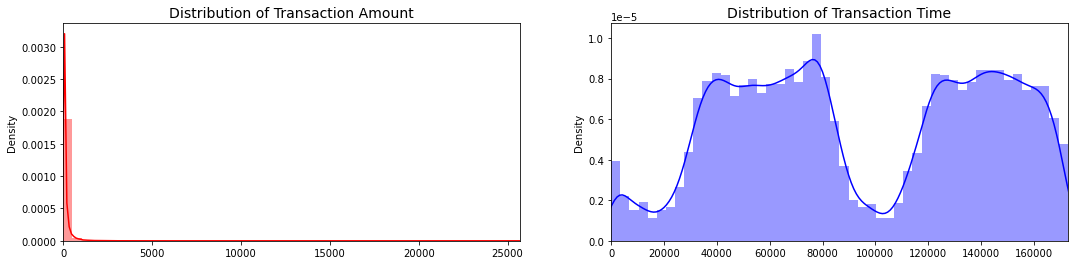

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df['Amount'].values
time_val = df['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

plt.show()

<h2> 확장 및 배포 </h2>
<a id="배포"></a>
커널의 이 단계에서는 먼저 <b>시간</b> 및 <b>금액 </b>으로 구성된 열의 크기를 조정할 것입니다. 시간과 양은 다른 열과 같이 조정되어야 합니다. 반면에 사기 및 비 사기 사례의 동일한 양을 가지기 위해 데이터 프레임의 하위 샘플도 생성해야 하므로 거래가 사기인지 여부를 결정하는 패턴을 알고리즘이 더 잘 이해할 수 있습니다.

<h3> 하위 샘플이란 무엇입니까?</h3>
이 시나리오에서 하위 샘플은 사기 및 비 사기 거래 비율이 50/50인 데이터 프레임이 됩니다. 즉, 하위 샘플에는 동일한 양의 사기 및 비 사기 거래가 있습니다.

<h3> 하위 샘플을 만드는 이유는 무엇입니까?</h3>
이 노트북의 시작 부분에서 우리는 원본 데이터 프레임의 불균형이 심한 것을 보았습니다! 원본 데이터 프레임을 사용하면 다음 문제가 발생합니다.
<울>
<li><b>과적합: </b>우리의 분류 모델은 대부분의 경우 사기가 없다고 가정합니다! 우리가 모델에서 원하는 것은 사기가 발생했을 때 확실하게 하는 것입니다. </li>
<li><b>잘못된 상관관계:</b> "V" 기능이 무엇을 의미하는지 모르지만 이러한 각 기능이 불균형 데이터 프레임에서는 클래스와 기능 간의 진정한 상관 관계를 볼 수 없습니다. </li>
</ul>

<h3>요약: </h3>
<울>
<li> <b>조정된 양 </b> 및 <b> 조정된 시간 </b>은 조정된 값이 있는 열입니다. </li>
<li> 데이터 세트에는 사기 사례가 <b>492건 </b> 있으므로 새로운 하위 데이터 프레임을 생성하기 위해 사기가 아닌 사례 492건을 무작위로 얻을 수 있습니다. </li>
<li>492개의 사기 및 비 사기 사례를 연결하여 <b>새로운 하위 샘플을 만듭니다. </b></li>
</ul>

In [9]:
# 대부분의 데이터가 이미 크기가 조정되었으므로 나머지 열(amount 및 time)의 크기를 조정해야 합니다.
from sklearn.preprocessing import StandardScaler, RobustScaler

# RobustScaler는 이상치에 덜 취약합니다.
std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1)) # 특이치를 염두해둔 RobustScaler
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

In [10]:
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount) # 맨뒤 변수를 첫번째로 옯기기
df.insert(1, 'scaled_time', scaled_time)# 맨뒤 변수를 두번째로 옯기기

# Amount and Time are Scaled!
df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


### 데이터 분할(Original DataFrame)
<a id="splitting"></a>
<b> Random UnderSampling 기술</b>을 진행하기 전에 원본 데이터 프레임을 분리해야 합니다. <b> 왜? 테스트 목적을 위해 Random UnderSampling 또는 OverSampling 기술을 구현할 때 데이터를 분할하지만 우리는 이러한 기술 중 하나에 의해 생성된 테스트 세트가 아닌 원래 테스트 세트에서 모델을 테스트하기를 원한다는 것을 기억하십시오.</b> 주요 목표는 모델을 언더샘플링 및 오버샘플링(모델이 패턴을 감지할 수 있도록)한 데이터 프레임으로 모델을 맞추고 원래 테스트 세트에서 테스트합니다.

In [11]:
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

X = df.drop('Class', axis=1)
y = df['Class']

skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in skf.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values
print(original_Xtrain.shape, original_Xtest.shape, original_ytrain.shape, original_ytest.shape)


train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True) # array([0, 1]), array([227452, 394])
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True) # array([0, 1]), array([56863, 98])
print('-' * 100)

# 나눈 데이터셋(train/test)의 0,1 비율
print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset
Train: [ 30473  30496  31002 ... 284804 284805 284806] Test: [    0     1     2 ... 57017 57018 57019]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 30473  30496  31002 ... 113964 113965 113966]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 81609  82400  83053 ... 170946 170947 170948]
Train: [     0      1      2 ... 284804 284805 284806] Test: [150654 150660 150661 ... 227866 227867 227868]
Train: [     0      1      2 ... 227866 227867 227868] Test: [212516 212644 213092 ... 284804 284805 284806]
(227846, 30) (56961, 30) (227846,) (56961,)
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99827076 0.00172924]
[0.99827952 0.00172048]


## 무작위 언더샘플링:
<img src="http://contrib.scikit-learn.org/imbalanced-learn/stable/_images/sphx_glr_plot_random_under_sampler_001.png">

프로젝트의 이 단계에서 우리는 기본적으로 보다 <b> 균형 잡힌 데이터 세트 </b> 를 갖고 모델이 과적합되는 것을 피하기 위해 데이터를 제거하는 것으로 구성된 *"Random Under Sampling"*을 구현할 것입니다.

#### 단계:
<울>
<li>먼저 해야 할 일은 클래스가 얼마나 <b>불균형</b>인지 확인하는 것입니다(클래스 열에서 "value_counts()"를 사용하여 각 레이블의 양을 결정) </li>
<li><b>사기 거래 </b>(Fraud = "1")로 간주되는 인스턴스 수를 결정하면 <b>비사기 거래</b>를 사기 거래와 동일한 금액으로 가져와야 합니다. (50/50 비율을 원한다고 가정) 이는 492건의 사기 및 492건의 비사기 거래에 해당합니다. </li>
<li> 이 기술을 구현한 후 클래스와 관련하여 비율이 50/50인 데이터 프레임의 하위 샘플이 있습니다. 그런 다음 구현할 다음 단계는 이 스크립트를 실행할 때마다 모델이 특정 정확도를 유지할 수 있는지 확인하기 위해 <b>데이터를 섞는</b> 것입니다.</li>
</ul>

**참고:** "Random Under-Sampling"의 주요 문제는 <b>정보 손실</b>이 많기 때문에 분류 모델이 원하는 만큼 정확하지 않을 위험이 있다는 것입니다. b> (비사기 거래 284,315건에서 비사기 거래 492건)

In [13]:
# 우리의 클래스는 매우 편향되어 있으므로 클래스의 정규 분포를 가지려면 동등하게 만들어야 합니다.
# 서브샘플을 만들기 전에 데이터를 섞을 수 있습니다.
df = df.sample(frac=1) # 데이터 섞기

# amount of fraud classes 492 rows.
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])
new_df = normal_distributed_df.sample(frac=1, random_state=42)
new_df

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
44103,0.207643,-0.503953,1.187108,0.197527,-0.005261,0.866955,0.096189,-0.236065,0.148301,-0.054294,...,-0.040280,0.054420,0.100704,-0.225825,-0.341203,0.739539,-0.306905,0.003305,0.009011,0
234633,-0.285195,0.744381,1.261324,2.726800,-5.435019,5.342759,1.447043,-1.442584,-0.898702,0.123062,...,0.313332,0.209086,-0.425938,-0.154440,-0.018820,0.632234,0.192922,0.468181,0.280486,1
269782,-0.199259,0.929064,0.030575,0.732028,0.089890,-0.802783,0.598855,-0.538619,0.858617,0.018576,...,-0.060654,-0.248125,-0.619363,0.018734,-0.524455,-0.484292,0.153181,0.235530,0.080722,0
30314,-0.201076,-0.573620,-2.044489,3.368306,-3.937111,5.623120,-3.079232,-1.253474,-5.778880,1.707428,...,1.112028,1.483594,0.834311,-0.148486,0.001669,-0.038996,0.389526,1.300236,0.549940,1
93424,-0.293440,-0.238255,-1.348042,2.522821,-0.782432,4.083047,-0.662280,-0.598776,-1.943552,-0.329579,...,0.348896,1.079871,-0.352026,-0.218358,0.125866,-0.074180,0.179116,0.612580,0.234206,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183106,-0.307413,0.481279,0.224414,2.994499,-3.432458,3.986519,3.760233,0.165640,1.099378,-0.654557,...,-0.200846,0.491337,-0.984223,-0.421979,-1.048058,0.726412,0.268625,0.283689,0.419102,1
101509,4.164047,-0.197782,-1.739334,-1.304655,0.314103,0.053740,-0.058696,0.071260,0.694862,-0.313270,...,-1.463994,-0.665172,-0.632078,-0.421176,-0.400774,-0.001640,-0.495162,0.031633,0.066280,1
199905,-0.130371,0.569779,1.981899,-0.165623,-1.468646,0.795698,0.125458,-0.326336,-0.138316,0.016419,...,-0.274902,-0.433873,-0.910155,0.254615,0.463135,-0.011024,-0.521054,0.021107,-0.019086,0
83297,4.152868,-0.292708,-8.257111,-4.814461,-5.365307,1.204230,-3.347420,-1.331601,-1.967893,1.295438,...,-1.233987,0.436390,-0.077553,-3.091624,-0.390201,-0.288689,-0.340004,0.039819,-1.007900,1


## 동등하게 분배 및 상관:
<a id="상관관계"></a>
이제 데이터 프레임의 균형이 올바르게 조정되었으므로 <b>분석</b> 및 <b>데이터 사전 처리</b>를 더 진행할 수 있습니다.

Distribution of the Classes in the subsample dataset
0    0.5
1    0.5
Name: Class, dtype: float64


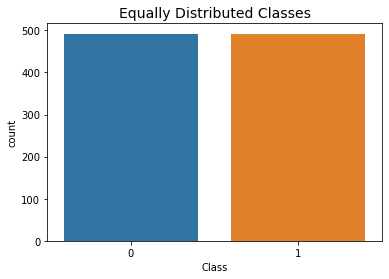

In [14]:
print('Distribution of the Classes in the subsample dataset')
print(new_df['Class'].value_counts()/len(new_df))

sns.countplot('Class', data=new_df)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

<h3> 상관 행렬 </h3>
상관 행렬은 데이터 이해의 핵심입니다. 특정 거래가 사기인지 여부에 큰 영향을 미치는 기능이 있는지 알고 싶습니다. 그러나 어떤 기능이 사기 거래와 관련하여 높은 양의 상관 관계 또는 음의 상관 관계가 있는지 확인하려면 올바른 데이터 프레임(하위 샘플)을 사용하는 것이 중요합니다.

### 요약 및 설명:
<울>
<li><b>음의 상관 관계: </b>V17, V14, V12 및 V10은 음의 상관 관계가 있습니다. 이 값이 낮을수록 최종 결과가 사기 거래가 될 가능성이 높아집니다. </li>
<li> <b> 양의 상관 관계: </b> V2, V4, V11 및 V19는 양의 상관 관계가 있습니다. 이 값이 높을수록 최종 결과가 사기 거래가 될 가능성이 높아집니다. </li>
<li> <b>BoxPlots: </b> 사기 및 비 사기 거래에서 이러한 기능의 분포를 더 잘 이해하기 위해 상자 그림을 사용할 것입니다. </li>
</ul>


**참고: ** 상관 행렬의 하위 샘플을 사용해야 합니다. 그렇지 않으면 상관 행렬이 클래스 간의 높은 불균형의 영향을 받습니다. 이것은 원본 데이터 프레임의 높은 클래스 불균형으로 인해 발생합니다.

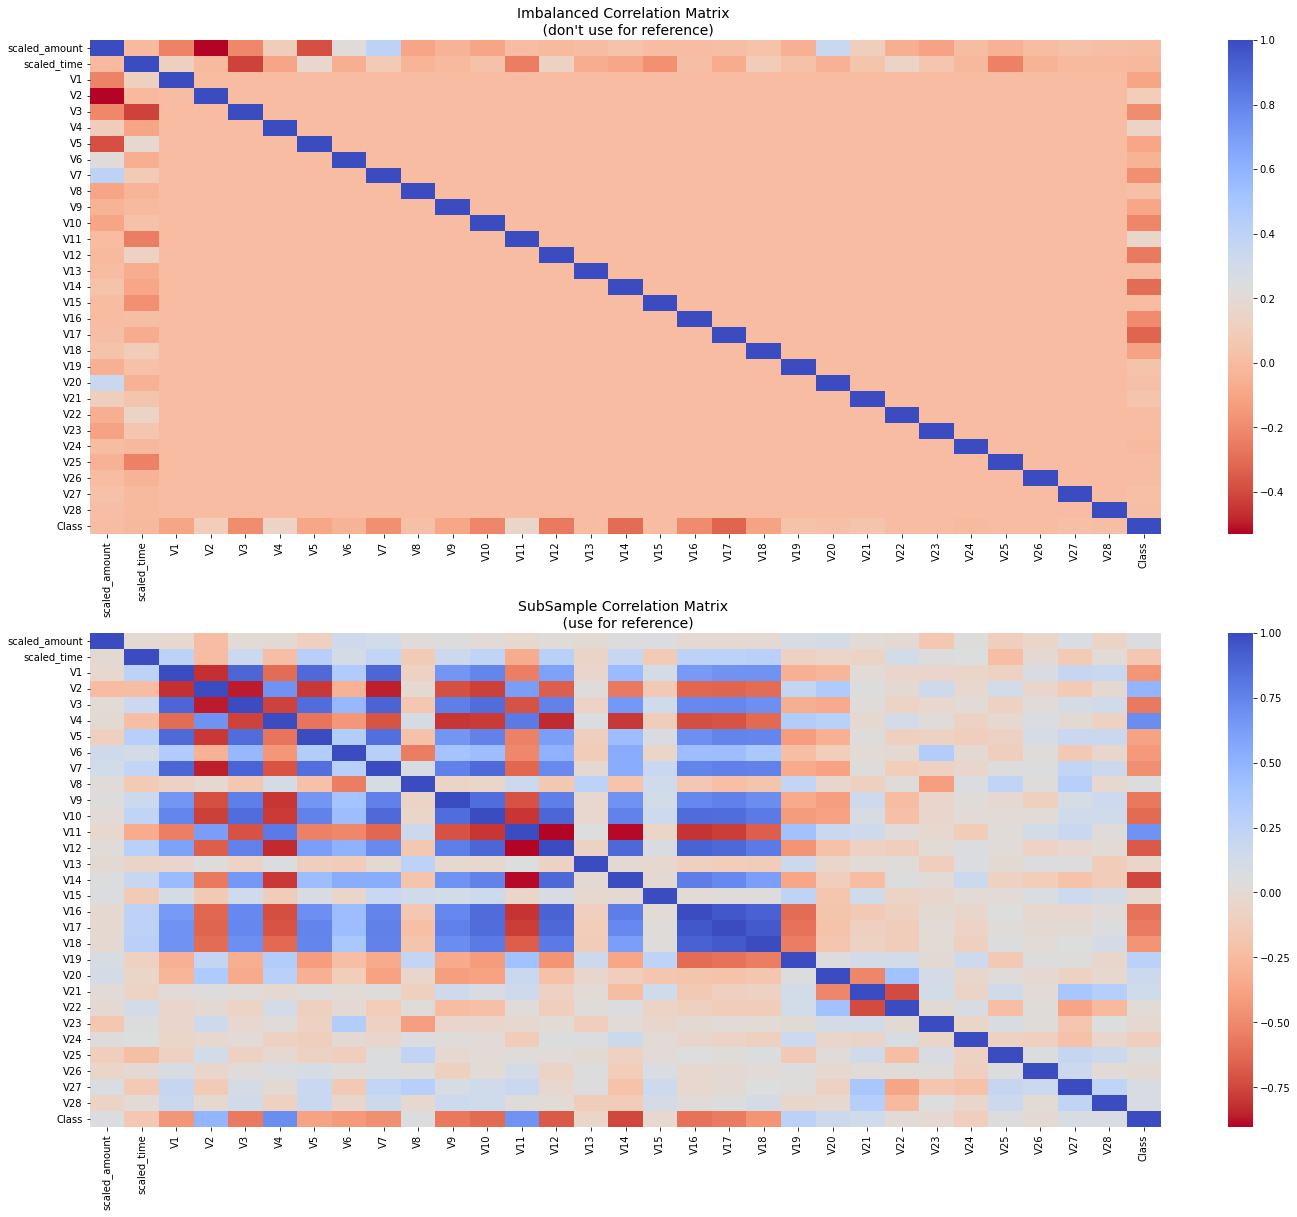

In [15]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# 전체 데이터프레임
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)

# 일부 데이터프레임
sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()

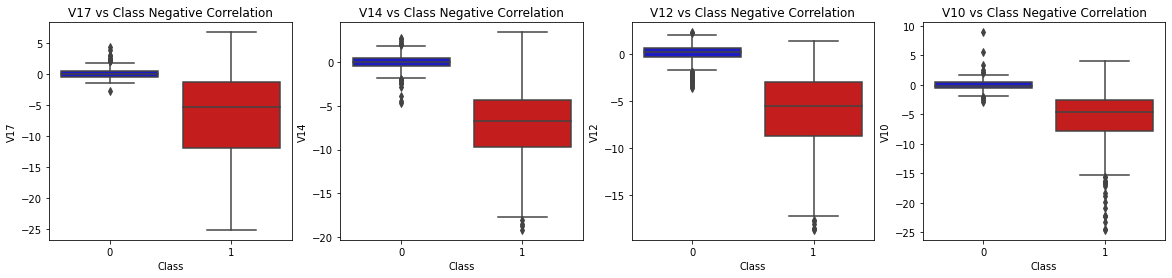

In [16]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# 음의 상곤관계
sns.boxplot(x="Class", y="V17", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('V17 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V14", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('V14 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V12", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('V12 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V10", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('V10 vs Class Negative Correlation')

plt.show()

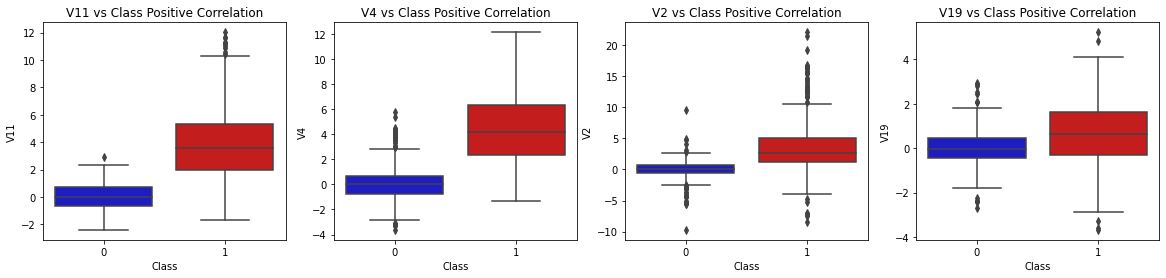

In [17]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# 양의 상곤관계
sns.boxplot(x="Class", y="V11", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('V11 vs Class Positive Correlation')

sns.boxplot(x="Class", y="V4", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('V4 vs Class Positive Correlation')

sns.boxplot(x="Class", y="V2", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('V2 vs Class Positive Correlation')

sns.boxplot(x="Class", y="V19", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('V19 vs Class Positive Correlation')

plt.show()

## 이상 감지:
<a id="anomaly"></a>
<img src="https://discourse-cdn-sjc1.com/business6/uploads/analyticsvidhya/original/2X/d/d11281b44c2e440b36aaf29156b5032105d2d06b.png">


이 섹션의 주요 목표는 클래스와 높은 상관 관계가 있는 기능에서 "극단적인 이상값"을 제거하는 것입니다. 이것은 우리 모델의 정확도에 긍정적인 영향을 미칠 것입니다. <br><br>


### 사분위수 범위 방법:
<울>
<li> <b>사분위수 범위(IQR): </b> 75번째 백분위수와 25번째 백분위수 간의 차이로 이를 계산합니다. 우리의 목표는 75번째 및 25번째 백분위수를 초과하는 임계값을 생성하여 일부 인스턴스가 이 임계값을 초과하는 경우 해당 인스턴스가 삭제되도록 하는 것입니다. </li>
<li> <b>Boxplots: </b> 25번째 백분위수와 75번째 백분위수(사각형의 양쪽 끝)를 쉽게 볼 수 있을 뿐만 아니라 극단적인 이상값(하위 및 상위 극단 너머에 있는 점)도 쉽게 볼 수 있습니다. </li>
</ul>

### 이상치 제거 트레이드오프:
우리는 이상치를 제거하기 위한 임계값을 어디까지 원하는지 주의해야 합니다. 숫자(예: 1.5)에 (사분위수 범위)를 곱하여 임계값을 결정합니다. 이 임계값이 높을수록 더 적은 이상값을 감지하고(더 높은 숫자로 곱하기: 3), 이 임계값이 낮을수록 더 많은 이상값을 감지합니다. <br><br>

**상충관계: **
임계값이 낮을수록 더 많은 이상값이 제거되지만 우리는 이상값보다 "극단적인 이상값"에 더 집중하고 싶습니다. 왜요? 정보 손실의 위험이 있어 모델의 정확도가 낮아질 수 있기 때문입니다. 이 임계값을 사용하여 분류 모델의 정확도에 어떤 영향을 미치는지 확인할 수 있습니다.


### 요약:
<울>
<li> <b> 분포 시각화: </b> 먼저 일부 이상값을 제거하는 데 사용할 기능의 분포를 시각화하는 것으로 시작합니다. V14는 V12 및 V10에 비해 가우스 분포가 있는 유일한 기능입니다. </li>
<li><b>임계값 결정: </b> iqr을 곱하는 데 사용할 숫자를 결정한 후(낮은 이상값이 더 많이 제거됨) q25 - 임계값 (하한 극한 임계값) 및 q75 + 임계값 추가 (상한 극한 임계값). </li>
<li> <b>조건부 ​​삭제: </b> 마지막으로 "임계값"이 두 극단 모두에서 초과되면 인스턴스가 제거된다는 조건부 삭제를 생성합니다. </li>
<li> <b> 상자 그림 표현: </b> 상자 그림을 통해 "극단적인 이상값"의 수가 상당히 감소했음을 시각화합니다. </li>
</ul>

**참고:** 이상치 감소를 구현한 후 정확도가 3% 이상 향상되었습니다! 일부 이상값은 모델의 정확도를 왜곡할 수 있지만 극단적인 정보 손실을 피해야 합니다. 그렇지 않으면 모델이 과소적합될 위험이 있습니다.


**참고**: 사분위수 범위 방법에 대한 추가 정보: <a src="https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/"> 통계 사용 방법 데이터의 이상값 식별 </a> by Jason Brownless(Machine Learning Mastery 블로그)

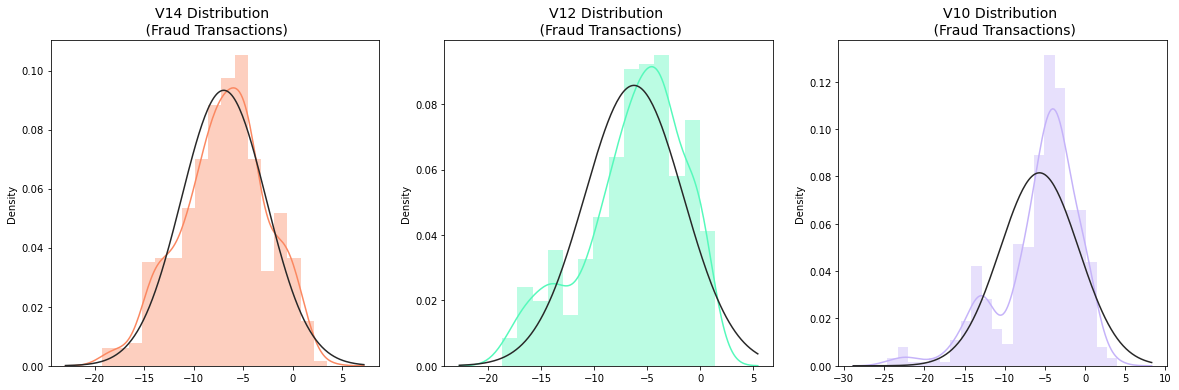

In [18]:
from scipy.stats import norm

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 6))

v14_fraud_dist = new_df['V14'].loc[new_df['Class'] == 1].values
sns.distplot(v14_fraud_dist, ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('V14 Distribution \n (Fraud Transactions)', fontsize=14)

v12_fraud_dist = new_df['V12'].loc[new_df['Class'] == 1].values
sns.distplot(v12_fraud_dist, ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('V12 Distribution \n (Fraud Transactions)', fontsize=14)

v10_fraud_dist = new_df['V10'].loc[new_df['Class'] == 1].values
sns.distplot(v10_fraud_dist, ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('V10 Distribution \n (Fraud Transactions)', fontsize=14)

plt.show()

In [19]:
# # -----> V14 이상치 제거(레이블과 상관관계가 가장 높은 음수)
v14_fraud = new_df['V14'].loc[new_df['Class'] == 1].values
q1, q3 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q1, q3))

v14_iqr = q3-q1
v14_lower, v14_upper = q1-1.5*v14_iqr, q3+1.5*v14_iqr
outliers = [x for x in v14_fraud if x < v14_lower or x > v14_upper]
new_df = new_df.drop(new_df[(new_df['V14'] > v14_upper) | (new_df['V14'] < v14_lower)].index)

# -----> V12 사기 거래에서 이상값 제거
v12_fraud = new_df['V12'].loc[new_df['Class'] == 1].values
q1, q3 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q1, q3))

v12_iqr = q3-q1
v12_lower, v12_upper = q1-1.5*v12_iqr, q3+1.5*v12_iqr
outliers = [x for x in v12_fraud if x < v12_lower or x > v12_upper]
new_df = new_df.drop(new_df[(new_df['V12'] > v12_upper) | (new_df['V12'] < v12_lower)].index)


# Removing outliers V10 Feature
v10_fraud = new_df['V10'].loc[new_df['Class'] == 1].values
q1, q3 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)

v10_iqr = q3-q1
v10_lower, v10_upper = q1-1.5*v10_iqr, q3+1.5*v10_iqr
outliers = [x for x in v10_fraud if x < v10_lower or x > v10_upper]
new_df = new_df.drop(new_df[(new_df['V10'] > v10_upper) | (new_df['V10'] < v10_lower)].index)

print('Number of Instances after outliers removal: {}'.format(len(new_df)))

Quartile 25: -9.692722964972386 | Quartile 75: -4.282820849486865
Quartile 25: -8.67303320439115 | Quartile 75: -2.893030568676315
Number of Instances after outliers removal: 947


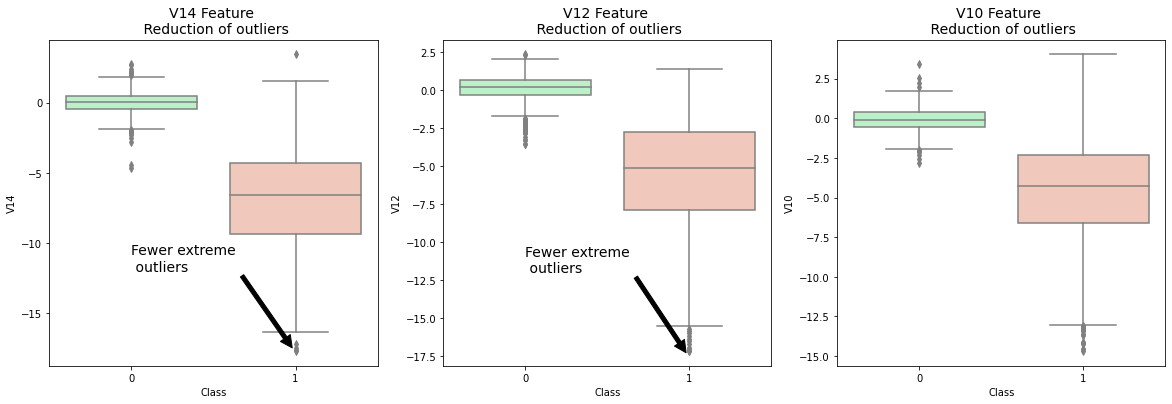

In [20]:
f,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,6))

colors = ['#B3F9C5', '#f9c5b3']
# Boxplots with outliers removed
# Feature V14
sns.boxplot(x="Class", y="V14", data=new_df,ax=ax1, palette=colors)
ax1.set_title("V14 Feature \n Reduction of outliers", fontsize=14)
ax1.annotate('Fewer extreme \n outliers', xy=(0.98, -17.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Feature 12
sns.boxplot(x="Class", y="V12", data=new_df, ax=ax2, palette=colors)
ax2.set_title("V12 Feature \n Reduction of outliers", fontsize=14)
ax2.annotate('Fewer extreme \n outliers', xy=(0.98, -17.3), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Feature V10
sns.boxplot(x="Class", y="V10", data=new_df, ax=ax3, palette=colors)
ax3.set_title("V10 Feature \n Reduction of outliers", fontsize=14)
ax3.annotate('Fewer extreme \n outliers', xy=(0.95, -16.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)


plt.show()

<h2>차원 축소 및 클러스터링: </h2>
<a id="클러스터링"></a>

<h3>t-SNE 이해하기: </h3>
이 알고리즘을 이해하려면 다음 용어를 이해해야 합니다. <br>
<울>
<li> <b> 유클리드 거리 </b></li>
<li> <b>조건부 확률</b> </li>
<li><b>정규 및 T-분포도</b> </li>
</ul>

**참고:** 간단한 교육용 비디오를 보려면 다음을 참조하십시오. <a href="https://www.youtube.com/watch?v=NEaUSP4YerM"> StatQuest: t-SNE, 명확하게 설명 </a> 조슈아 스타머


<h3> 요약: </h3>
<울>
<li>t-SNE 알고리즘은 데이터 세트에서 사기 및 비 사기 사례를 매우 정확하게 클러스터링할 수 있습니다. </li>
<li> 하위 샘플은 매우 작지만 t-SNE 알고리즘은 모든 시나리오에서 클러스터를 매우 정확하게 감지할 수 있습니다(t-SNE를 실행하기 전에 데이터 세트를 섞습니다)</li>
<li> 이것은 추가 예측 모델이 사기 사례와 비 사기 사례를 구분하는 데 꽤 잘 수행할 것임을 시사합니다. </li>
</ul>

In [21]:
# New_df is from the random undersample data (fewer instances)
X = new_df.drop('Class', axis=1)
y = new_df['Class']

# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

# TruncatedSVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X.values)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))

T-SNE took 4.1 s
PCA took 0.089 s
Truncated SVD took 0.0037 s


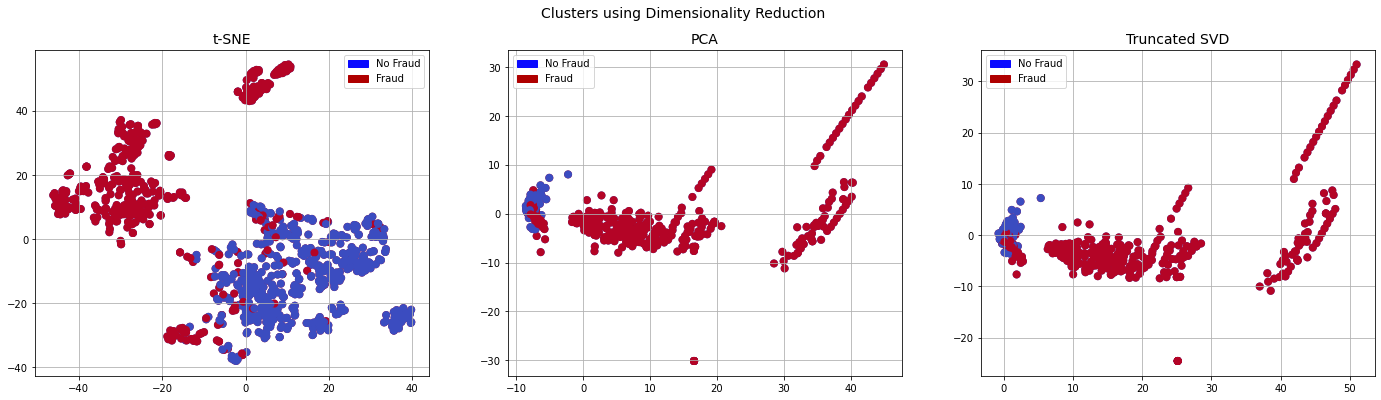

In [22]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)

blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')

# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)
ax1.legend(handles=[blue_patch, red_patch])

# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)
ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)

ax3.grid(True)
ax3.legend(handles=[blue_patch, red_patch])

plt.show()

<h2> 분류자(언더샘플링): </h2>
<a id="classifiers"></a>
이 섹션에서는 4가지 유형의 분류기를 교육하고 어떤 분류기가 <b>사기 거래</b>를 탐지하는 데 더 효과적인지 결정할 것입니다. 데이터를 훈련 세트와 테스트 세트로 분할하고 레이블에서 기능을 분리하기 전에.

## 요약:
<울>
<li> <b> 로지스틱 회귀 </b> 분류기는 대부분의 경우 다른 세 분류기보다 정확합니다. (우리는 로지스틱 회귀 분석을 추가로 분석할 것입니다) </li>
<li><b> GridSearchCV </b> 는 분류자에 대한 최상의 예측 점수를 제공하는 매개변수를 결정하는 데 사용됩니다. </li>
<li> Logistic Regression은 ROC(수신 운영 특성 점수)가 가장 높기 때문에 LogisticRegression이 <b> 사기 </b> 및 <b> 사기가 아닌 </b> 거래를 매우 정확하게 구분합니다.</li>
</ul>

## 학습 곡선:
<울>
<li>훈련 점수와 교차 검증 점수 사이의 <b>차이가 클수록</b> 모델이 <b>과적합(높은 분산)</b>일 가능성이 높아집니다.</li>
<li> 훈련 세트와 교차 검증 세트 모두에서 점수가 낮은 경우</b> 이는 우리 모델이 <b>과소적합(높은 편향)</b></li>임을 나타냅니다.
<li><b> 로지스틱 회귀 분류기</b>는 훈련 세트와 교차 검증 세트 모두에서 최고 점수를 보여줍니다.</li>
</ul>

In [23]:
# 교차 검증 전 언더샘플링(과적합이 발생하기 쉬움)
X = new_df.drop('Class', axis=1)
y = new_df['Class']

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [26]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(757, 30) (190, 30) (757,) (190,)


In [27]:
classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

In [28]:
from sklearn.model_selection import cross_val_score

for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Classifiers:  LogisticRegression Has a training score of 93.0 % accuracy score
Classifiers:  KNeighborsClassifier Has a training score of 92.0 % accuracy score
Classifiers:  SVC Has a training score of 93.0 % accuracy score
Classifiers:  DecisionTreeClassifier Has a training score of 89.0 % accuracy score


In [29]:
from sklearn.model_selection import GridSearchCV

# Logistic Regression 
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)

log_reg = grid_log_reg.best_estimator_

# KNN
knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, y_train)

knears_neighbors = grid_knears.best_estimator_

# Support Vector Classifier
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)

svc = grid_svc.best_estimator_

# DecisionTree Classifier
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)

tree_clf = grid_tree.best_estimator_

In [53]:
grid_log_reg.best_estimator_

LogisticRegression(C=0.1)

In [30]:
log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')

knears_score = cross_val_score(knears_neighbors, X_train, y_train, cv=5)
print('Knears Neighbors Cross Validation Score', round(knears_score.mean() * 100, 2).astype(str) + '%')

svc_score = cross_val_score(svc, X_train, y_train, cv=5)
print('Support Vector Classifier Cross Validation Score', round(svc_score.mean() * 100, 2).astype(str) + '%')

tree_score = cross_val_score(tree_clf, X_train, y_train, cv=5)
print('DecisionTree Classifier Cross Validation Score', round(tree_score.mean() * 100, 2).astype(str) + '%')

Logistic Regression Cross Validation Score:  93.13%
Knears Neighbors Cross Validation Score 92.34%
Support Vector Classifier Cross Validation Score 92.99%
DecisionTree Classifier Cross Validation Score 91.41%


In [31]:
undersample_X = df.drop('Class', axis=1)
undersample_y = df['Class']

for train_index, test_index in skf.split(undersample_X, undersample_y):
    print("Train:", train_index, "Test:", test_index)
    undersample_Xtrain, undersample_Xtest = undersample_X.iloc[train_index], undersample_X.iloc[test_index]
    undersample_ytrain, undersample_ytest = undersample_y.iloc[train_index], undersample_y.iloc[test_index]
    
undersample_Xtrain = undersample_Xtrain.values
undersample_Xtest = undersample_Xtest.values
undersample_ytrain = undersample_ytrain.values
undersample_ytest = undersample_ytest.values 

undersample_accuracy = []
undersample_precision = []
undersample_recall = []
undersample_f1 = []
undersample_auc = []

# NearMiss 기법 구현
# NearMiss의 분포(이 변수를 사용하지 않을 레이블이 어떻게 분포하는지 확인하기 위해)
X_nearmiss, y_nearmiss = NearMiss().fit_resample(undersample_X.values, undersample_y.values)
print('NearMiss Label Distribution: {}'.format(Counter(y_nearmiss)))
# Cross Validating the right way

# 
for train, test in skf.split(undersample_Xtrain, undersample_ytrain):
    undersample_pipeline = imbalanced_make_pipeline(NearMiss(sampling_strategy='majority'), log_reg) # SMOTE happens during Cross Validation not before..
    undersample_model = undersample_pipeline.fit(undersample_Xtrain[train], undersample_ytrain[train])
    undersample_prediction = undersample_model.predict(undersample_Xtrain[test])
    
    undersample_accuracy.append(undersample_pipeline.score(original_Xtrain[test], original_ytrain[test]))
    undersample_precision.append(precision_score(original_ytrain[test], undersample_prediction))
    undersample_recall.append(recall_score(original_ytrain[test], undersample_prediction))
    undersample_f1.append(f1_score(original_ytrain[test], undersample_prediction))
    undersample_auc.append(roc_auc_score(original_ytrain[test], undersample_prediction))

Train: [ 51670  51702  52463 ... 284804 284805 284806] Test: [    0     1     2 ... 56970 56971 56972]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 51670  51702  52463 ... 113936 113937 113938]
Train: [     0      1      2 ... 284804 284805 284806] Test: [104565 104758 104781 ... 170890 170891 170892]
Train: [     0      1      2 ... 284804 284805 284806] Test: [167814 168370 168487 ... 227846 227847 227848]
Train: [     0      1      2 ... 227846 227847 227848] Test: [224612 225025 226641 ... 284804 284805 284806]
NearMiss Label Distribution: Counter({0: 492, 1: 492})


In [32]:
# Let's Plot LogisticRegression Learning Curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator1, estimator2, estimator3, estimator4, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20,14), sharey=True)
    if ylim is not None:
        plt.ylim(*ylim)
    # First Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator1, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax1.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax1.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax1.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax1.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax1.set_title("Logistic Regression Learning Curve", fontsize=14)
    ax1.set_xlabel('Training size (m)')
    ax1.set_ylabel('Score')
    ax1.grid(True)
    ax1.legend(loc="best")
    
    # Second Estimator 
    train_sizes, train_scores, test_scores = learning_curve(
        estimator2, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax2.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax2.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax2.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax2.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax2.set_title("Knears Neighbors Learning Curve", fontsize=14)
    ax2.set_xlabel('Training size (m)')
    ax2.set_ylabel('Score')
    ax2.grid(True)
    ax2.legend(loc="best")
    
    # Third Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator3, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax3.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax3.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax3.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax3.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax3.set_title("Support Vector Classifier \n Learning Curve", fontsize=14)
    ax3.set_xlabel('Training size (m)')
    ax3.set_ylabel('Score')
    ax3.grid(True)
    ax3.legend(loc="best")
    
    # Fourth Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator4, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax4.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax4.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax4.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax4.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax4.set_title("Decision Tree Classifier \n Learning Curve", fontsize=14)
    ax4.set_xlabel('Training size (m)')
    ax4.set_ylabel('Score')
    ax4.grid(True)
    ax4.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\HOME\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

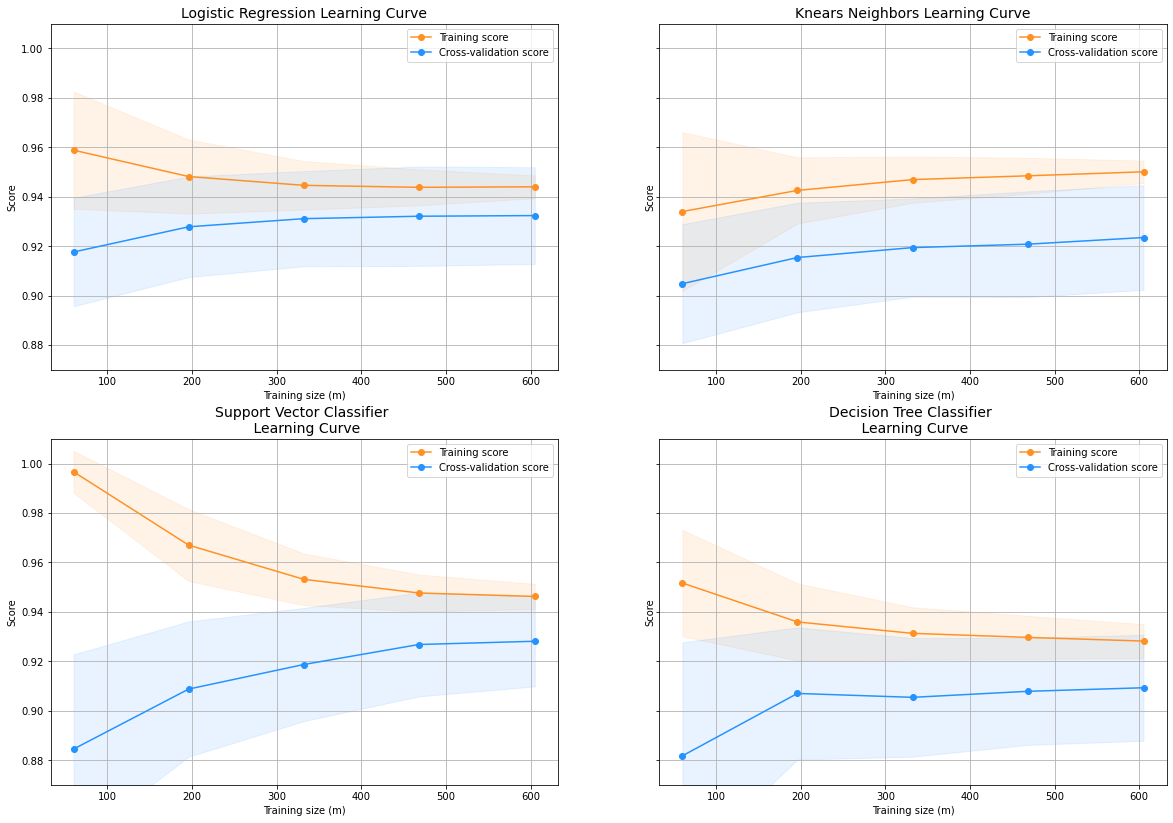

In [33]:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
plot_learning_curve(log_reg, knears_neighbors, svc, tree_clf, X_train, y_train, (0.87, 1.01), cv=cv, n_jobs=4)

In [34]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict

log_reg_pred = cross_val_predict(log_reg, X_train, y_train, cv=5, method="decision_function")

knears_pred = cross_val_predict(knears_neighbors, X_train, y_train, cv=5)

svc_pred = cross_val_predict(svc, X_train, y_train, cv=5, method="decision_function")

tree_pred = cross_val_predict(tree_clf, X_train, y_train, cv=5)

In [35]:
from sklearn.metrics import roc_auc_score

print('Logistic Regression: ', roc_auc_score(y_train, log_reg_pred))
print('KNears Neighbors: ', roc_auc_score(y_train, knears_pred))
print('Support Vector Classifier: ', roc_auc_score(y_train, svc_pred))
print('Decision Tree Classifier: ', roc_auc_score(y_train, tree_pred))

Logistic Regression:  0.9649541875647959
KNears Neighbors:  0.9196426069657317
Support Vector Classifier:  0.9598755919190787
Decision Tree Classifier:  0.9115448737706296


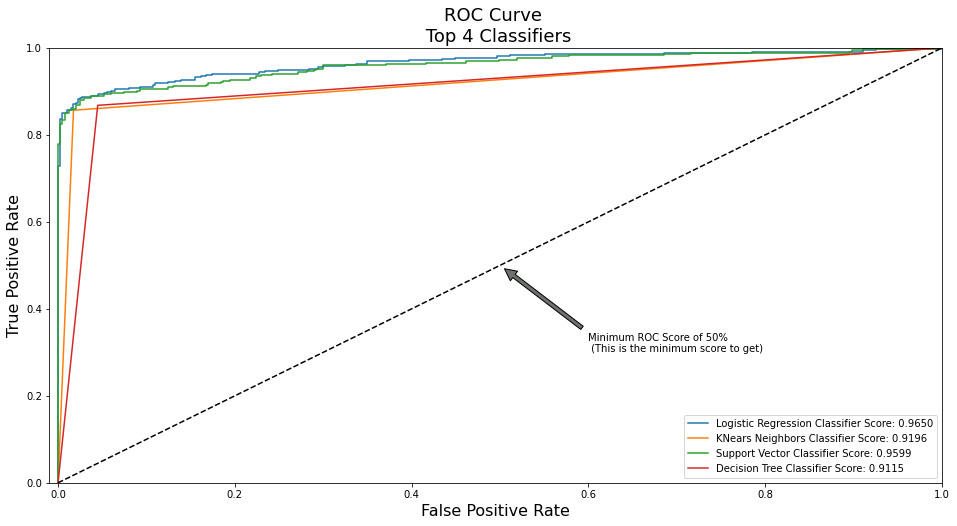

In [36]:
log_fpr, log_tpr, log_thresold = roc_curve(y_train, log_reg_pred)
knear_fpr, knear_tpr, knear_threshold = roc_curve(y_train, knears_pred)
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_train, svc_pred)
tree_fpr, tree_tpr, tree_threshold = roc_curve(y_train, tree_pred)


def graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve \n Top 4 Classifiers', fontsize=18)
    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_train, log_reg_pred)))
    plt.plot(knear_fpr, knear_tpr, label='KNears Neighbors Classifier Score: {:.4f}'.format(roc_auc_score(y_train, knears_pred)))
    plt.plot(svc_fpr, svc_tpr, label='Support Vector Classifier Score: {:.4f}'.format(roc_auc_score(y_train, svc_pred)))
    plt.plot(tree_fpr, tree_tpr, label='Decision Tree Classifier Score: {:.4f}'.format(roc_auc_score(y_train, tree_pred)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()
    
graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr)
plt.show()

## A Deeper Look into LogisticRegression:
<a id="logistic"></a>
In this section we will ive a deeper look into the <b> logistic regression classifier</b>.


### Terms:
<ul>
<li><b>True Positives:</b> Correctly Classified Fraud Transactions </li>
<li><b>False Positives:</b> Incorrectly Classified Fraud Transactions</li>
<li> <b>True Negative:</b> Correctly Classified Non-Fraud Transactions</li>
<li> <b>False Negative:</b> Incorrectly Classified Non-Fraud Transactions</li>
<li><b>Precision: </b>  True Positives/(True Positives + False Positives)  </li>
<li><b> Recall: </b> True Positives/(True Positives + False Negatives)   </li>
<li> Precision as the name says, says how precise (how sure) is our model in detecting fraud transactions while recall is the amount of fraud cases our model is able to detect.</li>
<li><b>Precision/Recall Tradeoff: </b> The more precise (selective) our model is, the less cases it will detect. Example: Assuming that our model has a precision of 95%, Let's say there are only 5 fraud cases in which the model is 95% precise or more that these are fraud cases. Then let's say there are 5 more cases that our model considers 90% to be a fraud case, if we lower the precision there are more cases that our model will be able to detect. </li>
</ul>

### Summary:
<ul>
<li> <b>Precision starts to descend</b> between 0.90 and 0.92 nevertheless, our precision score is still pretty high and still we have a descent recall score. </li>

</ul>

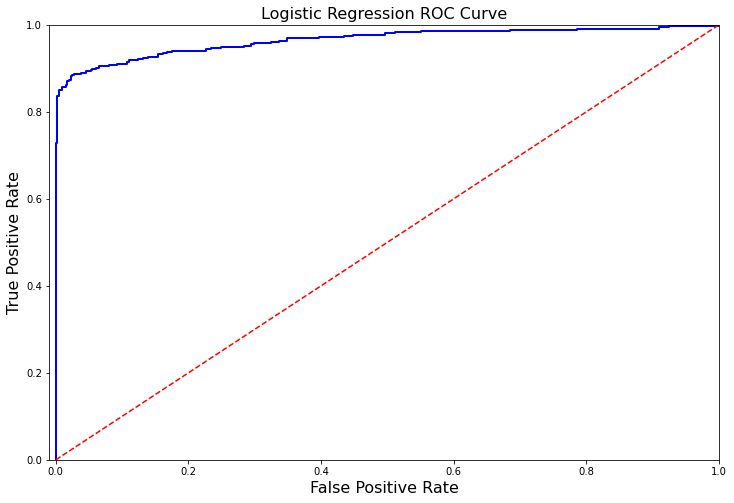

In [37]:
def logistic_roc_curve(log_fpr, log_tpr):
    plt.figure(figsize=(12,8))
    plt.title('Logistic Regression ROC Curve', fontsize=16)
    plt.plot(log_fpr, log_tpr, 'b-', linewidth=2)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.axis([-0.01,1,0,1])
    
    
logistic_roc_curve(log_fpr, log_tpr)
plt.show()

In [38]:
from sklearn.metrics import precision_recall_curve

precision, recall, threshold = precision_recall_curve(y_train, log_reg_pred)

In [39]:
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
y_pred = log_reg.predict(X_train)

# Overfitting Case
print('---' * 45)
print('Overfitting: \n')
print('Recall Score: {:.2f}'.format(recall_score(y_train, y_pred)))
print('Precision Score: {:.2f}'.format(precision_score(y_train, y_pred)))
print('F1 Score: {:.2f}'.format(f1_score(y_train, y_pred)))
print('Accuracy Score: {:.2f}'.format(accuracy_score(y_train, y_pred)))
print('---' * 45)

# How it should look like
print('---' * 45)
print('How it should be:\n')
print("Accuracy Score: {:.2f}".format(np.mean(undersample_accuracy)))
print("Precision Score: {:.2f}".format(np.mean(undersample_precision)))
print("Recall Score: {:.2f}".format(np.mean(undersample_recall)))
print("F1 Score: {:.2f}".format(np.mean(undersample_f1)))
print('---' * 45)

---------------------------------------------------------------------------------------------------------------------------------------
Overfitting: 

Recall Score: 0.88
Precision Score: 0.83
F1 Score: 0.85
Accuracy Score: 0.86
---------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------
How it should be:

Accuracy Score: 0.76
Precision Score: 0.00
Recall Score: 0.22
F1 Score: 0.00
---------------------------------------------------------------------------------------------------------------------------------------


In [40]:
undersample_y_score = log_reg.decision_function(original_Xtest)

In [41]:
from sklearn.metrics import average_precision_score

undersample_average_precision = average_precision_score(original_ytest, undersample_y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      undersample_average_precision))

Average precision-recall score: 0.07


Text(0.5, 1.0, 'UnderSampling Precision-Recall curve: \n Average Precision-Recall Score =0.07')

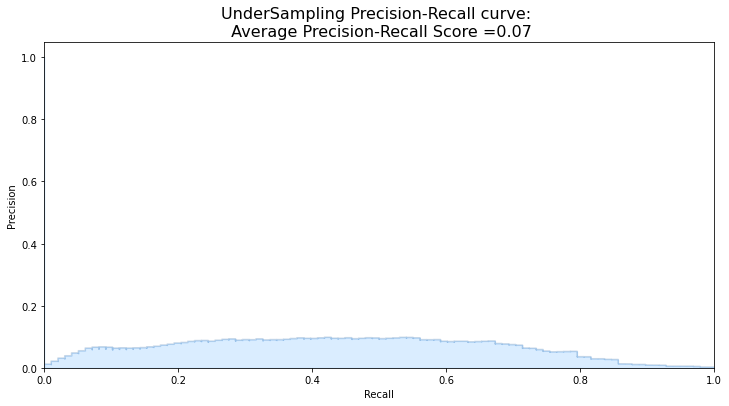

In [42]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(original_ytest, undersample_y_score)

plt.step(recall, precision, color='#004a93', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#48a6ff')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('UnderSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          undersample_average_precision), fontsize=16)

### SMOTE 기법(오버샘플링):
<a id="smote"></a>
<img src="https://raw.githubusercontent.com/rikunert/SMOTE_visualisation/master/SMOTE_R_visualisation_3.png", 너비=800>
<b>SMOTE</b>는 Synthetic Minority Over-sampling Technique의 약자입니다. Random UnderSampling과 달리 SMOTE는 클래스의 균등한 균형을 유지하기 위해 새로운 합성 포인트를 생성합니다. 이것은 "클래스 불균형 문제"를 해결하기 위한 또 다른 대안입니다. <br><br>


<b> SMOTE에 대한 이해: </b>
<울>
<li> <b> 클래스 불균형 해결: </b> SMOTE는 소수 클래스와 다수 클래스 간의 동등한 균형에 도달하기 위해 소수 클래스에서 종합 점수를 만듭니다. </li>
<li><b>합성 포인트의 위치: </b> SMOTE는 소수 클래스의 가장 가까운 이웃 사이의 거리를 선택하고 이 거리 사이에서 합성 포인트를 생성합니다. </li>
<li> <b>최종 효과: </b> 임의의 언더샘플링과 달리 행을 삭제할 필요가 없기 때문에 더 많은 정보가 유지됩니다.</li>
<li><b> 정확도 || 시간 절충: </b> SMOTE가 임의의 언더샘플링보다 더 정확할 가능성이 높지만 앞서 언급한 것처럼 제거된 행이 없기 때문에 훈련하는 데 더 많은 시간이 걸립니다.</li>

</ul>

### 교차 검증 과적합 실수:
## 교차 검증 중 과적합:
우리의 언더샘플 분석에서 저는 여러분 모두와 공유하고 싶은 일반적인 실수를 보여주고 싶습니다. 간단합니다. 데이터를 언더샘플링하거나 오버샘플링하려면 교차 검증 전에 수행하지 않아야 합니다. 교차 유효성 검사를 구현하기 전에 유효성 검사 세트에 직접 영향을 미치기 때문에 "데이터 누출" 문제가 발생하기 때문입니다. <b>다음 섹션에서 놀라운 정밀도와 재현율 점수를 볼 수 있지만 실제로는 데이터가 과적합됩니다!</b>
### 잘못된 방법:
<img src="https://www.marcoaltini.com/uploads/1/3/2/3/13234002/2639934.jpg?401"><br>

앞서 언급했듯이 우리의 경우 소수 클래스("사기")를 얻고 교차 검증 전에 합성 포인트를 생성하면 교차 검증 프로세스의 "검증 세트"에 특정 영향을 미칩니다. 교차 검증이 작동하는 방식을 기억합시다. 데이터를 5개의 배치로 분할한다고 가정하면 데이터 세트의 4/5가 훈련 세트가 되고 1/5이 검증 세트가 됩니다. 테스트 세트는 건들면 안 됩니다! 교차 검증 "중" 합성 데이터 포인트(아래와 같이 이전 아님): <br>


### 옳은 길:
<img src="https://www.marcoaltini.com/uploads/1/3/2/3/13234002/9101820.jpg?372"> <br>
위에서 볼 수 있듯이 SMOTE는 교차 검증 프로세스의 "이전"이 아니라 "중" 교차 검증에 발생합니다. 검증 세트에 영향을 주지 않고 훈련 세트에 대해서만 합성 데이터가 생성됩니다.




**참조**:
<울>
<li><a src="https://www.marcoaltini.com/blog/dealing-with-imbalanced-data-undersampling-oversampling-and-proper-cross-validation">
불균형 데이터 처리: 언더샘플링, 오버샘플링 및 적절한 교차 검증 </a></li>

<li> <a src="http://rikunert.com/SMOTE_explained "> 멍청한 놈을 위한 SMOTE 설명 </a></li>
<li> <a src="https://www.youtube.com/watch?v=DQC_YE3I5ig&t=794s"> 기계 학습 - 오버샘플링 및 언더샘플링 - Python/ Scikit/ Scikit-Imblearn </a></li>
</ul>

In [43]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV

print('Length of X (train): {} | Length of y (train): {}'.format(len(original_Xtrain), len(original_ytrain)))
print('Length of X (test): {} | Length of y (test): {}'.format(len(original_Xtest), len(original_ytest)))

# List to append the score and then find the average
accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

# 모델
log_reg_sm = LogisticRegression()
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
rand_log_reg = RandomizedSearchCV(LogisticRegression(), log_reg_params, n_iter=4)


for train, test in skf.split(original_Xtrain, original_ytrain):
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_log_reg) # SMOTE happens during Cross Validation not before..
    model = pipeline.fit(original_Xtrain[train], original_ytrain[train])
    best_est = rand_log_reg.best_estimator_
    prediction = best_est.predict(original_Xtrain[test])
    
    accuracy_lst.append(pipeline.score(original_Xtrain[test], original_ytrain[test]))
    precision_lst.append(precision_score(original_ytrain[test], prediction))
    recall_lst.append(recall_score(original_ytrain[test], prediction))
    f1_lst.append(f1_score(original_ytrain[test], prediction))
    auc_lst.append(roc_auc_score(original_ytrain[test], prediction))
    
print('---' * 45)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst)))
print("precision: {}".format(np.mean(precision_lst)))
print("recall: {}".format(np.mean(recall_lst)))
print("f1: {}".format(np.mean(f1_lst)))
print('---' * 45)

Length of X (train): 227846 | Length of y (train): 227846
Length of X (test): 56961 | Length of y (test): 56961
---------------------------------------------------------------------------------------------------------------------------------------

accuracy: 0.9414743009119715
precision: 0.06098042241564661
recall: 0.9137293086660175
f1: 0.1125194816171553
---------------------------------------------------------------------------------------------------------------------------------------


In [44]:
labels = ['No Fraud', 'Fraud']
smote_prediction = best_est.predict(original_Xtest)
print(classification_report(original_ytest, smote_prediction, target_names=labels))

              precision    recall  f1-score   support

    No Fraud       1.00      0.99      0.99     56863
       Fraud       0.11      0.86      0.20        98

    accuracy                           0.99     56961
   macro avg       0.56      0.92      0.60     56961
weighted avg       1.00      0.99      0.99     56961



In [45]:
y_score = best_est.decision_function(original_Xtest)
average_precision = average_precision_score(original_ytest, y_score)

print('Average precision-recall score: {0:0.2f}'.format(average_precision))

Average precision-recall score: 0.75


Text(0.5, 1.0, 'OverSampling Precision-Recall curve: \n Average Precision-Recall Score =0.75')

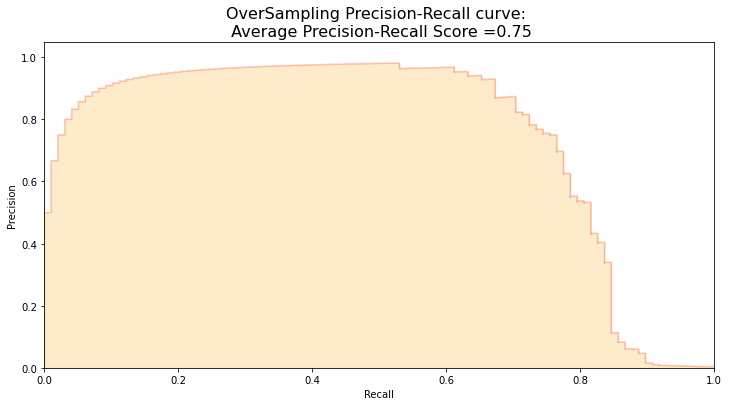

In [46]:
fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(original_ytest, y_score)

plt.step(recall, precision, color='r', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#F59B00')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('OverSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          average_precision), fontsize=16)

In [48]:
# SMOTE Technique (OverSampling) After splitting and Cross Validating
sm = SMOTE(sampling_strategy='minority', random_state=42)

Xsm_train, ysm_train = sm.fit_resample(original_Xtrain, original_ytrain)

In [49]:
# We Improve the score by 2% points approximately 
# Implement GridSearchCV and the other models.

# Logistic Regression
t0 = time.time()
log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm.fit(Xsm_train, ysm_train)
t1 = time.time()
print("Fitting oversample data took :{} sec".format(t1 - t0))

Fitting oversample data took :4.309025764465332 sec


# Test Data with Logistic Regression:
<a id="testing_logistic"></a>
## Confusion Matrix:
**Positive/Negative:** Type of Class (label) ["No", "Yes"]
**True/False:** Correctly or Incorrectly classified by the model.<br><br>

**True Negatives (Top-Left Square):** This is the number of **correctly** classifications of the "No" (No Fraud Detected) class. <br><br>

**False Negatives (Top-Right Square):** This is the number of **incorrectly** classifications of the "No"(No Fraud Detected) class. <br><br>

**False Positives (Bottom-Left Square):** This is the number of **incorrectly** classifications of the "Yes" (Fraud Detected) class <br><br>

**True Positives (Bottom-Right Square):** This is the number of **correctly** classifications of the "Yes" (Fraud Detected) class.


### Summary: 
<ul>
<li> <b>Random UnderSampling:</b> We will evaluate the final performance of the classification models in the random undersampling subset. <b>Keep in mind that this is not the data from the original dataframe. </b> </li>
<li> <b>Classification Models: </b> The models that performed the best were <b>logistic regression </b> and <b>support vector classifier (SVM)</b>  </li>
</ul>

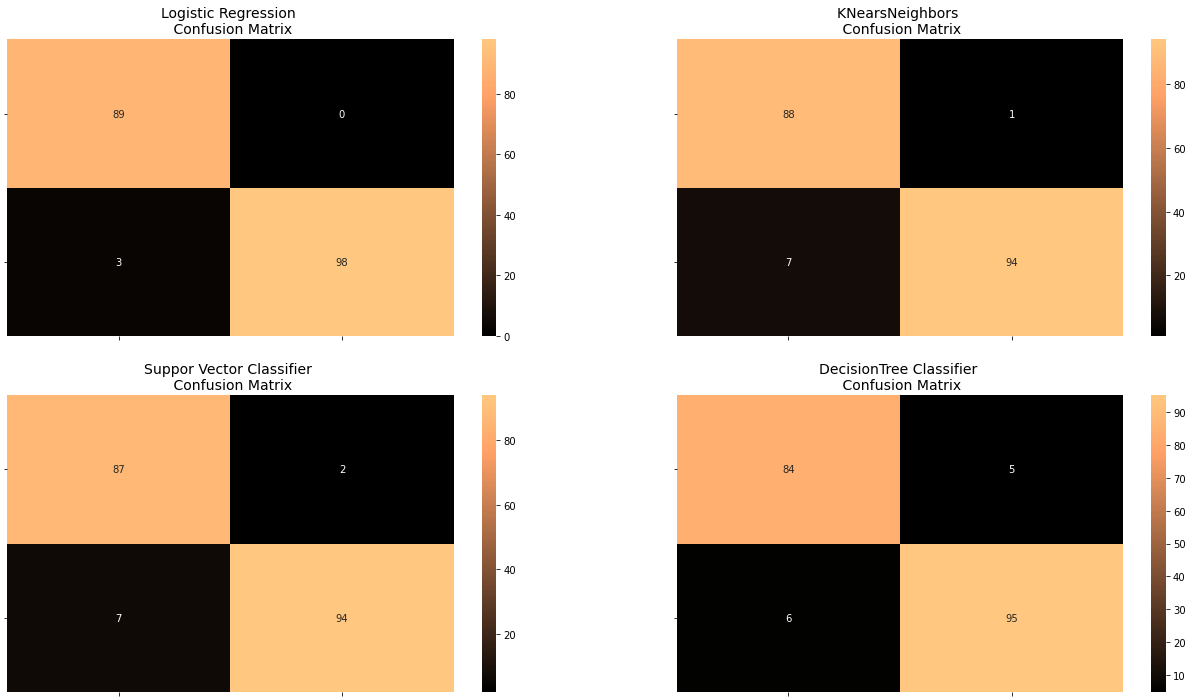

In [50]:
from sklearn.metrics import confusion_matrix

y_pred_log_reg = log_reg_sm.predict(X_test)
y_pred_knear = knears_neighbors.predict(X_test)
y_pred_svc = svc.predict(X_test)
y_pred_tree = tree_clf.predict(X_test)


log_reg_cf = confusion_matrix(y_test, y_pred_log_reg)
kneighbors_cf = confusion_matrix(y_test, y_pred_knear)
svc_cf = confusion_matrix(y_test, y_pred_svc)
tree_cf = confusion_matrix(y_test, y_pred_tree)

fig, ax = plt.subplots(2, 2,figsize=(22,12))


sns.heatmap(log_reg_cf, ax=ax[0][0], annot=True, cmap=plt.cm.copper)
ax[0, 0].set_title("Logistic Regression \n Confusion Matrix", fontsize=14)
ax[0, 0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0, 0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(kneighbors_cf, ax=ax[0][1], annot=True, cmap=plt.cm.copper)
ax[0][1].set_title("KNearsNeighbors \n Confusion Matrix", fontsize=14)
ax[0][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0][1].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(svc_cf, ax=ax[1][0], annot=True, cmap=plt.cm.copper)
ax[1][0].set_title("Suppor Vector Classifier \n Confusion Matrix", fontsize=14)
ax[1][0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(tree_cf, ax=ax[1][1], annot=True, cmap=plt.cm.copper)
ax[1][1].set_title("DecisionTree Classifier \n Confusion Matrix", fontsize=14)
ax[1][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][1].set_yticklabels(['', ''], fontsize=14, rotation=360)


plt.show()

In [51]:
from sklearn.metrics import classification_report


print('Logistic Regression:')
print(classification_report(y_test, y_pred_log_reg))

print('KNears Neighbors:')
print(classification_report(y_test, y_pred_knear))

print('Support Vector Classifier:')
print(classification_report(y_test, y_pred_svc))

print('Support Vector Classifier:')
print(classification_report(y_test, y_pred_tree))

Logistic Regression:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        89
           1       1.00      0.97      0.98       101

    accuracy                           0.98       190
   macro avg       0.98      0.99      0.98       190
weighted avg       0.98      0.98      0.98       190

KNears Neighbors:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96        89
           1       0.99      0.93      0.96       101

    accuracy                           0.96       190
   macro avg       0.96      0.96      0.96       190
weighted avg       0.96      0.96      0.96       190

Support Vector Classifier:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95        89
           1       0.98      0.93      0.95       101

    accuracy                           0.95       190
   macro avg       0.95      0.95      0.95       190
weighted

In [52]:
# Final Score in the test set of logistic regression
from sklearn.metrics import accuracy_score

# Logistic Regression with Under-Sampling
y_pred = log_reg.predict(X_test)
undersample_score = accuracy_score(y_test, y_pred)

# Logistic Regression with SMOTE Technique (Better accuracy with SMOTE t)
y_pred_sm = best_est.predict(original_Xtest)
oversample_score = accuracy_score(original_ytest, y_pred_sm)

d = {'Technique': ['Random UnderSampling', 'Oversampling (SMOTE)'], 'Score': [undersample_score, oversample_score]}
final_df = pd.DataFrame(data=d)

# Move column
score = final_df['Score']
final_df.drop('Score', axis=1, inplace=True)
final_df.insert(1, 'Score', score)

# Note how high is accuracy score it can be misleading! 
final_df

,Technique,Score
0,Random UnderSampling,0.984211
1,Oversampling (SMOTE),0.987922


## 신경망 테스트 랜덤 언더샘플링 데이터 대 오버샘플링(SMOTE):
<a id="neural_networks"></a>
이 섹션에서는 우리가 (undersample 또는 oversample(SMOTE))에서 구현한 두 가지 로지스틱 회귀 모델 중 사기 및 비 사기 탐지에 더 나은 정확도를 갖는 간단한 신경망(하나의 은닉 레이어 포함)을 구현합니다. 업무. <br><br>

### 우리의 주요 목표:
우리의 주요 목표는 무작위 언더샘플링 및 오버샘플링 데이터 프레임 모두에서 간단한 신경망이 어떻게 작동하는지 탐구하고 비 사기 및 사기 사례를 모두 정확하게 예측할 수 있는지 확인하는 것입니다. 사기에만 집중하지 않는 이유는 무엇입니까? 당신이 카드 소지자이고 상품을 구매한 후 은행의 알고리즘이 당신의 구매가 사기라고 생각했기 때문에 카드가 차단되었다고 상상해 보십시오. 그렇기 때문에 부정행위 적발에만 중점을 두는 것이 아니라 부정행위가 아닌 거래를 정확하게 분류하는 것도 강조해야 합니다.


### 혼란 매트릭스:
다음은 혼동 행렬이 작동하는 방식입니다.
<울>
<li><b>상단 왼쪽 사각형: </b> 사기 거래가 없는 당사 모델에 따라 <b>정확하게</b> 분류된 금액입니다. </li>
<li> <b>오른쪽 상단 사각형:</b> 거래를 사기 사례로 <b>잘못 </b> 분류했지만 실제 레이블은 <b> 사기가 아닙니다 </b> . </li>
<li><b>왼쪽 아래 사각형:</b> 거래 금액이 <b> 부정확하게 </b> 분류되어 사기 사례가 아닌 것으로 표시되지만 실제 레이블은 <b>사기 </b>입니다. </li>
<li><b> 오른쪽 하단 사각형:</b> 사기 거래 모델에 따라 <b>정확하게</b> 분류된 금액입니다. </li>
</ul>

### 요약(Keras || 무작위 언더샘플링):
<울>
<li><b>데이터 세트: </b> 테스트의 이 마지막 단계에서 우리는 이 모델을 <b>무작위 언더샘플링된 하위 집합</b> 및 <b> 오버샘플링된 데이터세트(SMOTE) </b>에 맞출 것입니다. <b>원본 데이터 프레임 테스트 데이터</b> </li>를 사용하여 최종 결과를 예측하기 위해
<li> <b>신경망 구조: </b> 이전에 언급했듯이 이것은 하나의 입력 레이어(여기서 노드의 수는 기능의 수와 동일)와 바이어스 노드, 32개의 은닉 레이어로 구성된 간단한 모델입니다. 노드 및 두 개의 가능한 결과 0 또는 1로 구성된 하나의 출력 노드(사기 또는 사기 없음). </li>
<li> <b>기타 특성:</b> 학습률은 0.001, 우리가 사용할 옵티마이저는 AdamOptimizer, 이 시나리오에서 사용되는 활성화 함수는 "Relu"이며 최종 출력에 대해 사용할 것입니다. 희소 범주형 교차 엔트로피, 인스턴스 사례가 사기 또는 사기가 아닐 확률을 제공합니다(예측은 둘 중 가장 높은 확률을 선택합니다.) </li>
</ul>

In [60]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense
from tensorflow.keras.optimizers import Adam
from keras.metrics import categorical_crossentropy

n_inputs = X_train.shape[1]

undersample_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

undersample_model.summary()

undersample_model.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
undersample_model.fit(X_train, y_train, validation_split=0.2, batch_size=25, epochs=20, shuffle=True, verbose=2)
undersample_predictions = undersample_model.predict(original_Xtest, batch_size=200, verbose=0)
undersample_fraud_predictions = undersample_model.predict(original_Xtest, batch_size=200, verbose=0).argmax(axis=-1)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 30)                930       
                                                                 
 dense_10 (Dense)            (None, 32)                992       
                                                                 
 dense_11 (Dense)            (None, 2)                 66        
                                                                 
Total params: 1,988
Trainable params: 1,988
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
25/25 - 1s - loss: 0.5406 - accuracy: 0.6711 - val_loss: 0.4605 - val_accuracy: 0.7697 - 501ms/epoch - 20ms/step
Epoch 2/20
25/25 - 0s - loss: 0.3604 - accuracy: 0.8678 - val_loss: 0.3604 - val_accuracy: 0.8684 - 62ms/epoch - 2ms/step
Epoch 3/20
25/25 - 0s - loss: 0.2719 - accuracy: 0.9091 - val_loss: 0.

In [61]:
import itertools

# Create a confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[55140  1723]
 [    7    91]]
Confusion matrix, without normalization
[[56863     0]
 [    0    98]]


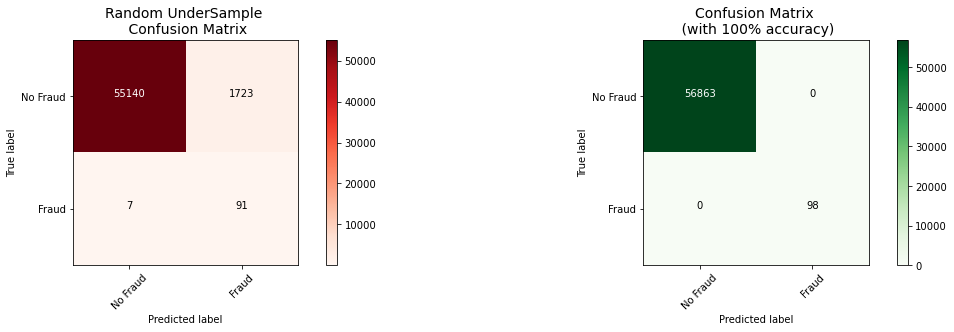

In [62]:
undersample_cm = confusion_matrix(original_ytest, undersample_fraud_predictions)
actual_cm = confusion_matrix(original_ytest, original_ytest)
labels = ['No Fraud', 'Fraud']

fig = plt.figure(figsize=(16,8))

fig.add_subplot(221)
plot_confusion_matrix(undersample_cm, labels, title="Random UnderSample \n Confusion Matrix", cmap=plt.cm.Reds)

fig.add_subplot(222)
plot_confusion_matrix(actual_cm, labels, title="Confusion Matrix \n (with 100% accuracy)", cmap=plt.cm.Greens)

### Keras || OverSampling (SMOTE):


In [63]:
n_inputs = Xsm_train.shape[1]

oversample_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

oversample_model.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
oversample_model.fit(Xsm_train, ysm_train, validation_split=0.2, batch_size=300, epochs=20, shuffle=True, verbose=2)
oversample_predictions = oversample_model.predict(original_Xtest, batch_size=200, verbose=0)
oversample_fraud_predictions = oversample_model.predict(original_Xtest, batch_size=200, verbose=0).argmax(axis=-1)



Epoch 1/20
1214/1214 - 2s - loss: 0.0622 - accuracy: 0.9786 - val_loss: 0.0212 - val_accuracy: 0.9957 - 2s/epoch - 2ms/step
Epoch 2/20
1214/1214 - 2s - loss: 0.0133 - accuracy: 0.9970 - val_loss: 0.0063 - val_accuracy: 0.9998 - 2s/epoch - 1ms/step
Epoch 3/20
1214/1214 - 2s - loss: 0.0074 - accuracy: 0.9985 - val_loss: 0.0044 - val_accuracy: 0.9999 - 2s/epoch - 1ms/step
Epoch 4/20
1214/1214 - 2s - loss: 0.0053 - accuracy: 0.9990 - val_loss: 0.0045 - val_accuracy: 0.9998 - 2s/epoch - 2ms/step
Epoch 5/20
1214/1214 - 2s - loss: 0.0042 - accuracy: 0.9992 - val_loss: 0.0021 - val_accuracy: 1.0000 - 2s/epoch - 1ms/step
Epoch 6/20
1214/1214 - 2s - loss: 0.0032 - accuracy: 0.9994 - val_loss: 0.0015 - val_accuracy: 0.9998 - 2s/epoch - 1ms/step
Epoch 7/20
1214/1214 - 2s - loss: 0.0030 - accuracy: 0.9994 - val_loss: 7.7747e-04 - val_accuracy: 1.0000 - 2s/epoch - 1ms/step
Epoch 8/20
1214/1214 - 2s - loss: 0.0023 - accuracy: 0.9996 - val_loss: 0.0036 - val_accuracy: 1.0000 - 2s/epoch - 2ms/step
Epoc

Confusion matrix, without normalization
[[56853    10]
 [   30    68]]
Confusion matrix, without normalization
[[56863     0]
 [    0    98]]


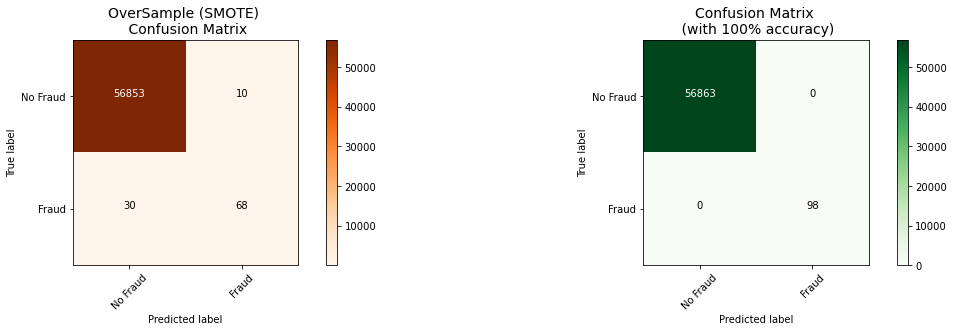

In [64]:
oversample_smote = confusion_matrix(original_ytest, oversample_fraud_predictions)
actual_cm = confusion_matrix(original_ytest, original_ytest)
labels = ['No Fraud', 'Fraud']

fig = plt.figure(figsize=(16,8))

fig.add_subplot(221)
plot_confusion_matrix(oversample_smote, labels, title="OverSample (SMOTE) \n Confusion Matrix", cmap=plt.cm.Oranges)

fig.add_subplot(222)
plot_confusion_matrix(actual_cm, labels, title="Confusion Matrix \n (with 100% accuracy)", cmap=plt.cm.Greens)

### 결론:
불균형 데이터 세트에 SMOTE를 구현하면 레이블의 불균형을 해결하는 데 도움이 되었습니다(사기 거래보다 사기가 더 없음). 그럼에도 불구하고 오버샘플링된 데이터세트의 신경망이 언더샘플링된 데이터세트를 사용하는 우리 모델보다 부정확한 사기 거래를 덜 예측하는 경우가 있다는 점을 여전히 언급해야 합니다. 그러나 이상값 제거는 무작위 언더샘플 데이터 세트에서만 구현되었으며 오버샘플링된 데이터 세트에서는 구현되지 않았음을 기억하십시오. 또한, 우리의 언더샘플 데이터에서 우리 모델은 다수의 사례에 대해 사기가 아닌 거래를 올바르게 감지할 수 없으며 대신 이러한 비 사기 거래를 사기 사례로 잘못 분류합니다. 우리 모델이 해당 거래를 사기 거래로 분류했기 때문에 정기적으로 구매하는 사람들이 카드를 차단했다고 상상해 보세요. 이는 금융 기관에 큰 불이익이 될 것입니다. 고객 불만 및 고객 불만이 증가할 것입니다. 이 분석의 다음 단계는 과표본 데이터 세트에서 이상값을 제거하고 테스트 세트의 정확도가 향상되는지 확인하는 것입니다. <br><br>

**참고:** 마지막으로 두 가지 유형의 데이터 프레임에서 데이터 셔플링을 구현했기 때문에 예측과 정확도가 변경될 수 있습니다. 가장 중요한 것은 우리 모델이 사기 및 사기 거래를 올바르게 분류할 수 있는지 확인하는 것입니다. 나는 더 많은 업데이트를 가져올 것입니다, 계속 지켜봐주세요!